In [1]:
import os
import json
import numpy as np
import torch.nn.functional as F

import torch
import torch.nn as nn
from torch.optim import AdamW
import cv2
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
# from torchvision.models import resnet18
from torchvision.models import resnet50
from torchvision.models import efficientnet_b3

import torchvision
from torchvision.transforms import transforms
from torchvision.transforms import ToTensor, Lambda
import torch.nn.functional as F
from torch.autograd import Variable
from glob import glob
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip ./drive/MyDrive/소재.zip -d ./zip_data


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./zip_data/pic_filter/359560.jpg  
  inflating: ./zip_data/pic_filter/359570.jpg  
  inflating: ./zip_data/pic_filter/359730.jpg  
  inflating: ./zip_data/pic_filter/359760.jpg  
  inflating: ./zip_data/pic_filter/360201.jpg  
  inflating: ./zip_data/pic_filter/360230.jpg  
  inflating: ./zip_data/pic_filter/360290.jpg  
  inflating: ./zip_data/pic_filter/360440.jpg  
  inflating: ./zip_data/pic_filter/360480.jpg  
  inflating: ./zip_data/pic_filter/360620.jpg  
  inflating: ./zip_data/pic_filter/360670.jpg  
  inflating: ./zip_data/pic_filter/360780.jpg  
  inflating: ./zip_data/pic_filter/360880.jpg  
  inflating: ./zip_data/pic_filter/360901.jpg  
  inflating: ./zip_data/pic_filter/360970.jpg  
  inflating: ./zip_data/pic_filter/360990.jpg  
  inflating: ./zip_data/pic_filter/361020.jpg  
  inflating: ./zip_data/pic_filter/361030.jpg  
  inflating: ./zip_data/pic_filter/361040.jpg  
  inflating: ./zip_data/pic_filter/361080.jpg  
  in

In [ ]:
zip_dir = "./zip_data"
save_dir = "./drive/MyDrive/laundry_step_ckpoint"

json_dir = "./zip_data/json_filter"
image_dir = "./zip_data/pic_filter"

json_files = []
image_files = []

for train_file in os.listdir(json_dir):
    json_files.append(os.path.join(json_dir, train_file))
    image_files.append(os.path.splitext(train_file)[0])

print("데이터 개수:", len(json_files))
print("이미지 개수:", len(image_files))
# print("json 장르", json_genre)
# print("image 장르", image_genre)

데이터 개수: 18003
이미지 개수: 18003


In [ ]:
# os.mkdir(f"{save_dir}")

In [ ]:
train_image, val_image, train_json, val_json = train_test_split(image_files, json_files, test_size=0.2, random_state=42, shuffle=True)
print(len(train_image), len(val_image))
print(len(train_json), len(val_json))

14402 3601
14402 3601


In [ ]:
clothes_class = ["아우터", "하의", "원피스", "상의"]
clothes_xy = {"outer_xy":None, "pants_xy":None, "onepiece_xy":None, "shirt_xy":None}
clothes_fabric = {"outer_fabric":None, "pants_fabric":None, "onepiece_fabric":None, "shirt_fabric":None}

train_image_dict = {}
valid_image_dict = {}

for file in tqdm(train_json):
    if os.path.splitext(file.split("/")[-1])[0] not in train_image: #이미지 파일 없을 때
        continue
    with open(file, "rb") as f:
        data = json.load(f)
        file_id = data['이미지 정보']['이미지 식별자']
        file_name=str(data['이미지 정보']['이미지 식별자'])+'.jpg'
        for cls, xy, fabric in zip(clothes_class, clothes_xy, clothes_fabric):
            clothes_xy[xy] = data['데이터셋 정보']['데이터셋 상세설명']['렉트좌표'][cls][0].values()
            if not clothes_xy[xy]:
                continue
#             if list(clothes_xy[xy])[2] < 1 or list(clothes_xy[xy])[3] < 1:
#                 print(file)
#                 continue
            try:
                clothes_fabric[fabric] = data['데이터셋 정보']['데이터셋 상세설명']['라벨링'][cls][0]['소재']
            except:
                pass
#                 print(file_name) #소재 없는 파일 
#                 print("--------------------")
        #print(clothes_xy)
        #print(clothes_fabric)

    for xy, fabric in zip(clothes_xy.values(), clothes_fabric.values()):
        if not xy:
            continue
        if list(xy)[2] < 1 or list(xy)[3] < 1:
            continue
        train_image_dict[(file_name, xy)] = fabric

        

for file in tqdm(val_json):
    if os.path.splitext(file.split("/")[-1])[0] not in val_image: #이미지 파일 없을 때
        continue
    with open(file, "rb") as f:
        data = json.load(f)
        file_name = str(data['이미지 정보']['이미지 식별자'])+'.jpg'
        for cls, xy, fabric in zip(clothes_class, clothes_xy, clothes_fabric):
            clothes_xy[xy] = data['데이터셋 정보']['데이터셋 상세설명']['렉트좌표'][cls][0].values()
            if not clothes_xy[xy]:
                continue
            try:
                clothes_fabric[fabric] = data['데이터셋 정보']['데이터셋 상세설명']['라벨링'][cls][0]['소재']
            except:
                pass
        # print(clothes_xy)
        # print(clothes_fabric)

    for xy, fabric in zip(clothes_xy.values(), clothes_fabric.values()):
        if not xy:
            continue
        if list(xy)[2] < 1 or list(xy)[3] < 1:
            continue        
        valid_image_dict[(file_name, xy)] = fabric     
        
# train_image_dict.items()
# valid_image_dict

100%|██████████| 3601/3601 [00:00<00:00, 7562.00it/s]


In [ ]:
#사용자 정의 데이터셋
class ClothDataset(Dataset):
    def __init__(self, train_image_dict, transform=None, data_dir=r"./zip_data/pic_filter"): 
        super().__init__()
        self.data_dir = data_dir
        self.train_image_dict = train_image_dict
        self.transform = transform
        self.image_files = []
        self.dict_label_to_num = {
            "메시": 0,"데님" : 0 , "우븐": 0 ,"패딩" : 0,
            "니트":1,"레이스":1,"린넨":1,"플리스":1,"네오프렌":1, "저지":1,"울/캐시미어" :1,"헤어 니트": 1,
            "퍼":2,"코듀로이":2,"실크":2,"스판덱스":2,"트위드":2,"자카드":2 ,"벨벳":2,"시폰":2,
            "스웨이드":3,"시퀸/글리터":3,"가죽":3,"비닐/PVC":3
          
        } #0:물세탁, 1:울세탁, 2:드라이클리닝, 3:기타
        self.setup()

    def setup(self):
        for (file_name, xy), fabric in self.train_image_dict.items():
            if not fabric:
                continue
            self.image_files.append((os.path.join(self.data_dir, file_name), xy, fabric))

    def __getitem__(self, idx):
        file_name, xy, fabric = self.image_files[idx]
        fabric=fabric[0]
        x, y, w, h = map(int, xy)
        im = Image.open(file_name)
        im = transforms.ToTensor()(im)
        im = transforms.Normalize((0.4,),(0.4,))(im) #######
        im = torchvision.transforms.functional.crop(im, y, x, h, w)
        im = transforms.Resize((150,150))(im) #,Image.BILINEAR
        # transform = transforms.RandomHorizontalFlip(p=1)
        # imgs = transform(im)
        
        # torchvision_transform=transforms.Compose([
        #                                 transforms.RandomHorizontalFlip(),
        #                                 transforms.ToTensor(),
        #                                 transforms.Normalize((0.1307,),(0.3081,))])
        # im = torchvision_transform(im)
        fabric_label = self.dict_label_to_num[fabric]
  
        
        return im, fabric_label
    
    def __len__(self):
        return len(self.image_files)

torchvision_transform=transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))])
torchvision_dataset = ClothDataset(train_image_dict,transform=torchvision_transform)

In [ ]:
# class ClothDataset(Dataset):
#     def __init__(self, train_image_dict, data_dir=r"./zip_data/pic_filter"): #C:\Users\dra04\fashion image\K-Fashion 이미지\Training\원천데이터
#         super().__init__()
#         self.data_dir = data_dir
#         self.train_image_dict = train_image_dict
#         self.image_files = []
#         self.dict_label_to_num = {
#             "퍼" : 0,
#             "니트" : 1,
            
#             "레이스" : 2,
#             "스웨이드" : 3,
#             "린넨" : 4,
            
#             "메시" : 5,
#             "코듀로이" : 6,
#             "플리스" : 7,
#             "시퀸/글리터" : 8,
#             "네오프렌" : 9,
#             "데님" : 10,
#             "실크" : 11,
#             "저지" : 12,
#             "스판덱스" : 13,
#             "트위드" : 14,
#             "자카드" : 15,
#             "벨벳" : 16,
#             "가죽" : 17,
#             "비닐/PVC" : 18,
            
#             "울/캐시미어" : 19,
#             "시폰" : 20,
            
#             "우븐" : 21,
#             "패딩" : 22,
#             "헤어 니트": 23
#         }
#         self.setup()

#     def setup(self):
#         for (file_name, xy), fabric in self.train_image_dict.items():
#             if not fabric:
#                 continue
#             self.image_files.append((os.path.join(self.data_dir, file_name), xy, fabric)) #os.path.join(data_dir+이미지명)/좌표/직물을 list에

#     def __getitem__(self, idx):
#         file_name, xy, fabric = self.image_files[idx]
#         fabric=fabric[0]
#         x, y, w, h = map(int, xy)
# #         
#         im = Image.open(file_name)
#         im = transforms.ToTensor()(im)
#         im = torchvision.transforms.functional.crop(im, y, x, h, w)
#         im = transforms.Resize((150,150))(im)

#         fabric_label = self.dict_label_to_num[fabric]
#         return im, fabric_label
    
#     def __len__(self):
#         return len(self.image_files)



In [ ]:
train_dataset = ClothDataset(train_image_dict)
valid_dataset = ClothDataset(valid_image_dict)
# print(train_dataset[0][0])
# print(len(torchvision_dataset))
print(len(train_dataset))
print(len(valid_dataset))

22446
5603


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


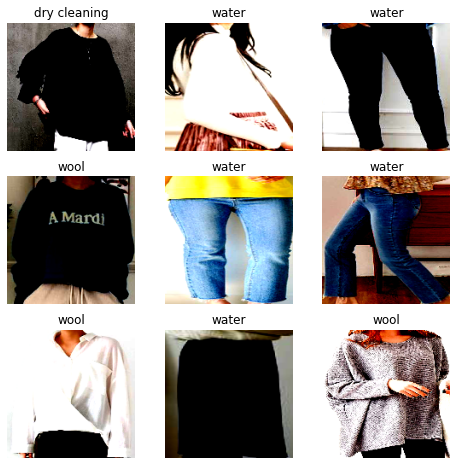

In [ ]:
classes=["water",
        "wool",
        "dry cleaning",
        "etc"] 

# y=train_dataset[18][1] #dict의 18번째 label-->label 값을 뜻한다
figure = plt.figure(figsize=(8,8))
cols, rows= 3,3

for i in range(1, cols*rows+1):
    sample_idx=torch.randint(len(train_dataset),size=(1,)).item()
    
    # img, label= train_dataset[sample_idx]
    img, label= torchvision_dataset[sample_idx]

    figure.add_subplot(rows, cols, i)
    title=classes[label]
    plt.title(title)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0))
plt.show()

In [ ]:
idx = np.random.randint(0, len(train_dataset))
print(idx)
title=classes[train_dataset[idx][1]]
plt.title(title)
plt.imshow(train_dataset[idx][0].permute(1,2,0))

In [ ]:
import torch.nn.functional as F

class efficientnet_b3(nn.Module): #Resnet50
    def __init__(self, num_classes):
        super().__init__()
        self.model = torchvision.models.efficientnet_b3(pretrained=True) #50
        

        self.fc = nn.Linear(1000, num_classes) #1000
        
    def forward(self, x):
        x = self.model(x)
        return self.fc(x)


In [ ]:
# class Resnet50(nn.Module): #Resnet50
#     def __init__(self, num_classes):
#         super().__init__()
#         self.model = torchvision.models.resnet50(pretrained=True) #50
        

#         self.fc = nn.Linear(1000, num_classes) #1000
#         # self.dropout=nn.Dropout(0.25) #############
#     def forward(self, x):
#         x = self.model(x)
#         return self.fc(x)


In [ ]:
# class Net(nn.Module):
#     def __Init__(self, input_shape=(3,32,32)):
#         super(Net, self).__init__()

#         self.conv1=nn.Conv2d(3,32,3)
#         self.conv2=nn.Conv2d(32,64,3)
#         self.conv3=nn.Conv2d(64,128,3)

#         self.pool=nn.MaxPool2d(2,2)

#         n_size=self._get_conv_output(input_shape)

#         self.fc1=nn.Linear(n_size,512)
#         self.fc2=nn.Linear(512,10)

#         self.dropout=nn.Dropout(0.25)

#     def dorward(self,x):
#         x=self._forward_features(x)
#         x=x.view(x.size(0),-1)
#         x=self.dropout(x)
#         x=F.relu(self.fc1(x))

#         x=self.dropout(x)
#         x=self.fc2(x)
#         return x


In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha]) #,long
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
BATCH_SIZE = 128 #32 작은 것보다 오히려 큰게 나을수도
EPOCHS =10
LOG_INTERVAL=30 #35
LEARNING_RATE=0.001 #0.001
# SAVE_DIR="./results"
torch.cuda.empty_cache()
device=torch.device("cuda") # if torch.cuda.is_available() else "cpu"

train_loader=DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True,shuffle=True)
# train_loader=DataLoader(torchvision_dataset,  batch_size=BATCH_SIZE, drop_last=True,shuffle=True)
valid_loader=DataLoader(valid_dataset, batch_size=BATCH_SIZE, drop_last=True,shuffle=True)


model = efficientnet_b3(num_classes=4).cuda() #gpu
# model = Resnet50(num_classes=4).cuda() #gpu

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.9) #1e-5
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.1)
# optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
scheduler = StepLR(optimizer, step_size=1, gamma=0.5) #0.5
best_val_acc = 0
best_val_loss = np.inf

for epoch in range(EPOCHS):
    model.train()
    loss_value=0
    matches=0
    for idx, batch in enumerate(tqdm(train_loader)): #train_loader
        inputs, labels=batch
        
        inputs=inputs.to(device)
        labels=labels.to(device)
        
        optimizer.zero_grad()
        outs=model(inputs)
                
        preds=torch.argmax(outs,dim=-1)    
        num_label=labels.tolist()     #😊
        num_pred=preds.tolist() 
        total_label.extend(num_label)
        total_pred.extend(num_pred)


        # l2_lambda = 0.001
        # l2_norm = sum(p.pow(2.0).sum()
        #           for p in model.parameters())

        loss = FocalLoss(gamma=5)(outs,labels)
        
        # loss = criterion(outs, labels)
        # loss = loss+l2_lambda*l2_norm

        loss.backward()
        optimizer.step()

        loss_value += loss.item()
        matches += (preds==labels).sum().item()
        if(idx+1) % LOG_INTERVAL==0:
            train_loss=loss_value / LOG_INTERVAL
            train_acc=matches / BATCH_SIZE / LOG_INTERVAL
            print(
                f"Epoch[{epoch}/{EPOCHS}]({idx + 1}/{len(train_loader)}) || " #train_loader
                f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%}"
            )
            torch.save(model.state_dict(), f"{save_dir}/{idx}.pth")
            loss_value = 0
            matches = 0
    scheduler.step()
    

    with torch.no_grad():
        print("Calculating validation results...")
        model.eval() #검증 모드,검증 목적은 최적의 epoch를 찾아 overfiting과 unseen data 문제 를 막는 것
        val_loss_items=[]
        val_acc_items=[]
        total_label=[]
        total_pred=[]

        for val_batch in tqdm(valid_loader):
            inputs, labels=val_batch
            inputs=inputs.to(device)
            labels=labels.to(device)

            outs=model(inputs)
            preds=torch.argmax(outs, dim=-1)

            num_label=labels.tolist()     #😊
            num_pred=preds.tolist() 
            total_label.extend(num_label)
            total_pred.extend(num_pred)


            loss_item = FocalLoss(gamma=5)(outs,labels).item()
            # loss_item = criterion(outs, labels).item()            
            acc_item = (labels == preds).sum().item()
            
            val_loss_items.append(loss_item)
            val_acc_items.append(acc_item)

        val_loss= np.sum(val_loss_items) / len(valid_loader)
        val_acc = np.sum(val_acc_items) / len(valid_dataset)
        best_val_loss = min(best_val_loss, val_loss) #검증용 데이터를 모델에 넣어 loss(MSE(used 손실함수))를 확인해 트레이닝이 잘 되고 있는지 확인(모델 사용)
        
        print(classification_report(total_label, total_pred, target_names=['class 0', 'class 1', 'class 2','class 3']))

        if val_acc > best_val_acc:
            print(f"New best model for val accuracy : {val_acc:4.2%}! saving the best model..")
            torch.save(model.state_dict(), f"{save_dir}/best.pth")
            best_val_acc = val_acc
        
        torch.save(model.state_dict(),f"{save_dir}/last.pth")
        print(
            f"[Val] acc : {val_acc:4.2%}, loss: {val_loss:4.2} || "
            f"best acc : {best_val_acc:4.2%}, best loss: {best_val_loss:4.2}"
        )
                  
    

 17%|█▋        | 29/175 [01:19<06:41,  2.75s/it]

Epoch[0/10](30/175) || training loss 0.2992 || training accuracy 48.52%


 34%|███▍      | 60/175 [02:45<05:20,  2.78s/it]

Epoch[0/10](60/175) || training loss 0.1717 || training accuracy 55.39%


 51%|█████▏    | 90/175 [04:08<03:59,  2.82s/it]

Epoch[0/10](90/175) || training loss 0.1545 || training accuracy 58.15%


 69%|██████▊   | 120/175 [05:31<02:34,  2.81s/it]

Epoch[0/10](120/175) || training loss 0.1447 || training accuracy 61.69%


 86%|████████▌ | 150/175 [06:54<01:09,  2.79s/it]

Epoch[0/10](150/175) || training loss 0.1415 || training accuracy 60.31%


100%|██████████| 175/175 [08:03<00:00,  2.76s/it]


Calculating validation results...


100%|██████████| 43/43 [01:34<00:00,  2.21s/it]


              precision    recall  f1-score   support

     class 0       0.78      0.53      0.63      1978
     class 1       0.61      0.89      0.72      2419
     class 2       0.61      0.37      0.46      1040
     class 3       0.55      0.09      0.15        67

    accuracy                           0.65      5504
   macro avg       0.64      0.47      0.49      5504
weighted avg       0.67      0.65      0.63      5504

New best model for val accuracy : 63.98%! saving the best model..
[Val] acc : 63.98%, loss: 0.13 || best acc : 63.98%, best loss: 0.13


 17%|█▋        | 29/175 [01:20<06:45,  2.77s/it]

Epoch[1/10](30/175) || training loss 0.1067 || training accuracy 67.37%


 34%|███▍      | 60/175 [02:45<05:22,  2.80s/it]

Epoch[1/10](60/175) || training loss 0.1013 || training accuracy 69.77%


 51%|█████▏    | 90/175 [04:06<03:57,  2.80s/it]

Epoch[1/10](90/175) || training loss 0.09938 || training accuracy 68.20%


 69%|██████▊   | 120/175 [05:29<02:34,  2.80s/it]

Epoch[1/10](120/175) || training loss 0.0991 || training accuracy 68.78%


 86%|████████▌ | 150/175 [06:51<01:10,  2.81s/it]

Epoch[1/10](150/175) || training loss 0.09868 || training accuracy 69.56%


100%|██████████| 175/175 [07:59<00:00,  2.74s/it]


Calculating validation results...


100%|██████████| 43/43 [01:35<00:00,  2.22s/it]


              precision    recall  f1-score   support

     class 0       0.70      0.66      0.68      1974
     class 1       0.69      0.82      0.75      2419
     class 2       0.66      0.44      0.53      1043
     class 3       0.36      0.31      0.33        68

    accuracy                           0.69      5504
   macro avg       0.60      0.56      0.57      5504
weighted avg       0.68      0.69      0.68      5504

New best model for val accuracy : 67.34%! saving the best model..
[Val] acc : 67.34%, loss: 0.11 || best acc : 67.34%, best loss: 0.11


 17%|█▋        | 29/175 [01:20<06:39,  2.74s/it]

Epoch[2/10](30/175) || training loss 0.07409 || training accuracy 74.38%


 34%|███▍      | 60/175 [02:45<05:21,  2.80s/it]

Epoch[2/10](60/175) || training loss 0.06654 || training accuracy 75.34%


 51%|█████     | 89/175 [04:05<03:58,  2.77s/it]

Epoch[2/10](90/175) || training loss 0.06693 || training accuracy 75.70%


 69%|██████▊   | 120/175 [05:30<02:33,  2.80s/it]

Epoch[2/10](120/175) || training loss 0.0689 || training accuracy 74.38%


 86%|████████▌ | 150/175 [06:53<01:09,  2.77s/it]

Epoch[2/10](150/175) || training loss 0.06942 || training accuracy 75.08%


100%|██████████| 175/175 [08:01<00:00,  2.75s/it]


Calculating validation results...


100%|██████████| 43/43 [01:34<00:00,  2.20s/it]


              precision    recall  f1-score   support

     class 0       0.73      0.66      0.69      1978
     class 1       0.70      0.82      0.75      2417
     class 2       0.66      0.53      0.59      1041
     class 3       0.58      0.26      0.36        68

    accuracy                           0.70      5504
   macro avg       0.67      0.57      0.60      5504
weighted avg       0.70      0.70      0.70      5504

New best model for val accuracy : 68.95%! saving the best model..
[Val] acc : 68.95%, loss: 0.11 || best acc : 68.95%, best loss: 0.11


 17%|█▋        | 30/175 [01:22<06:43,  2.78s/it]

Epoch[3/10](30/175) || training loss 0.05067 || training accuracy 79.19%


 34%|███▎      | 59/175 [02:42<05:31,  2.85s/it]

Epoch[3/10](60/175) || training loss 0.04667 || training accuracy 80.76%


 51%|█████▏    | 90/175 [04:09<03:57,  2.80s/it]

Epoch[3/10](90/175) || training loss 0.04553 || training accuracy 79.95%


 69%|██████▊   | 120/175 [05:32<02:36,  2.84s/it]

Epoch[3/10](120/175) || training loss 0.04681 || training accuracy 79.27%


 85%|████████▌ | 149/175 [06:52<01:11,  2.75s/it]

Epoch[3/10](150/175) || training loss 0.04459 || training accuracy 79.95%


100%|██████████| 175/175 [08:03<00:00,  2.76s/it]


Calculating validation results...


100%|██████████| 43/43 [01:35<00:00,  2.21s/it]


              precision    recall  f1-score   support

     class 0       0.64      0.74      0.69      1977
     class 1       0.76      0.65      0.70      2429
     class 2       0.60      0.65      0.62      1032
     class 3       0.58      0.23      0.33        66

    accuracy                           0.68      5504
   macro avg       0.64      0.57      0.58      5504
weighted avg       0.68      0.68      0.68      5504

[Val] acc : 66.45%, loss: 0.12 || best acc : 68.95%, best loss: 0.11


 17%|█▋        | 29/175 [01:18<06:37,  2.73s/it]

Epoch[4/10](30/175) || training loss 0.0397 || training accuracy 81.30%


 34%|███▎      | 59/175 [02:40<05:15,  2.72s/it]

Epoch[4/10](60/175) || training loss 0.03457 || training accuracy 83.23%


 51%|█████▏    | 90/175 [04:06<03:59,  2.82s/it]

Epoch[4/10](90/175) || training loss 0.03642 || training accuracy 82.60%


 68%|██████▊   | 119/175 [05:25<02:32,  2.73s/it]

Epoch[4/10](120/175) || training loss 0.03297 || training accuracy 83.12%


 86%|████████▌ | 150/175 [06:50<01:10,  2.82s/it]

Epoch[4/10](150/175) || training loss 0.03453 || training accuracy 81.93%


100%|██████████| 175/175 [07:59<00:00,  2.74s/it]


Calculating validation results...


100%|██████████| 43/43 [01:35<00:00,  2.22s/it]


              precision    recall  f1-score   support

     class 0       0.72      0.68      0.70      1976
     class 1       0.72      0.77      0.75      2419
     class 2       0.63      0.61      0.62      1041
     class 3       0.56      0.28      0.37        68

    accuracy                           0.70      5504
   macro avg       0.66      0.59      0.61      5504
weighted avg       0.70      0.70      0.70      5504

[Val] acc : 68.95%, loss: 0.14 || best acc : 68.95%, best loss: 0.11


 17%|█▋        | 29/175 [01:21<06:57,  2.86s/it]

Epoch[5/10](30/175) || training loss 0.02838 || training accuracy 84.61%


 34%|███▎      | 59/175 [02:44<05:21,  2.77s/it]

Epoch[5/10](60/175) || training loss 0.02923 || training accuracy 84.61%


 51%|█████▏    | 90/175 [04:09<03:56,  2.79s/it]

Epoch[5/10](90/175) || training loss 0.03094 || training accuracy 84.38%


 68%|██████▊   | 119/175 [05:29<02:34,  2.76s/it]

Epoch[5/10](120/175) || training loss 0.0301 || training accuracy 84.24%


 86%|████████▌ | 150/175 [06:55<01:10,  2.82s/it]

Epoch[5/10](150/175) || training loss 0.02809 || training accuracy 84.74%


100%|██████████| 175/175 [08:03<00:00,  2.77s/it]


Calculating validation results...


100%|██████████| 43/43 [01:34<00:00,  2.20s/it]


              precision    recall  f1-score   support

     class 0       0.71      0.69      0.70      1978
     class 1       0.72      0.78      0.75      2420
     class 2       0.66      0.57      0.62      1037
     class 3       0.55      0.32      0.40        69

    accuracy                           0.70      5504
   macro avg       0.66      0.59      0.62      5504
weighted avg       0.70      0.70      0.70      5504

New best model for val accuracy : 69.16%! saving the best model..
[Val] acc : 69.16%, loss: 0.15 || best acc : 69.16%, best loss: 0.11


 17%|█▋        | 30/175 [01:23<06:52,  2.84s/it]

Epoch[6/10](30/175) || training loss 0.0252 || training accuracy 85.00%


 34%|███▎      | 59/175 [02:43<05:16,  2.73s/it]

Epoch[6/10](60/175) || training loss 0.02561 || training accuracy 85.13%


 51%|█████     | 89/175 [04:05<03:56,  2.75s/it]

Epoch[6/10](90/175) || training loss 0.02576 || training accuracy 85.10%


 69%|██████▊   | 120/175 [05:31<02:35,  2.83s/it]

Epoch[6/10](120/175) || training loss 0.02601 || training accuracy 85.34%


 86%|████████▌ | 150/175 [06:54<01:10,  2.83s/it]

Epoch[6/10](150/175) || training loss 0.02615 || training accuracy 86.04%


100%|██████████| 175/175 [08:02<00:00,  2.76s/it]


Calculating validation results...


100%|██████████| 43/43 [01:36<00:00,  2.24s/it]


              precision    recall  f1-score   support

     class 0       0.73      0.68      0.70      1976
     class 1       0.72      0.79      0.75      2422
     class 2       0.64      0.61      0.62      1037
     class 3       0.55      0.32      0.40        69

    accuracy                           0.71      5504
   macro avg       0.66      0.60      0.62      5504
weighted avg       0.71      0.71      0.71      5504

New best model for val accuracy : 69.55%! saving the best model..
[Val] acc : 69.55%, loss: 0.15 || best acc : 69.55%, best loss: 0.11


 17%|█▋        | 30/175 [01:22<06:46,  2.80s/it]

Epoch[7/10](30/175) || training loss 0.02452 || training accuracy 86.12%


 34%|███▍      | 60/175 [02:43<05:17,  2.76s/it]

Epoch[7/10](60/175) || training loss 0.02398 || training accuracy 86.15%


 51%|█████     | 89/175 [04:02<03:50,  2.69s/it]

Epoch[7/10](90/175) || training loss 0.0235 || training accuracy 85.96%


 69%|██████▊   | 120/175 [05:27<02:31,  2.76s/it]

Epoch[7/10](120/175) || training loss 0.02469 || training accuracy 85.86%


 85%|████████▌ | 149/175 [06:47<01:12,  2.80s/it]

Epoch[7/10](150/175) || training loss 0.02236 || training accuracy 87.55%


100%|██████████| 175/175 [08:00<00:00,  2.74s/it]


Calculating validation results...


100%|██████████| 43/43 [01:37<00:00,  2.28s/it]


              precision    recall  f1-score   support

     class 0       0.72      0.68      0.70      1982
     class 1       0.73      0.78      0.75      2409
     class 2       0.65      0.61      0.63      1045
     class 3       0.54      0.29      0.38        68

    accuracy                           0.71      5504
   macro avg       0.66      0.59      0.62      5504
weighted avg       0.71      0.71      0.71      5504

New best model for val accuracy : 69.64%! saving the best model..
[Val] acc : 69.64%, loss: 0.16 || best acc : 69.64%, best loss: 0.11


 17%|█▋        | 29/175 [01:21<06:51,  2.82s/it]

Epoch[8/10](30/175) || training loss 0.0236 || training accuracy 86.61%


 34%|███▍      | 60/175 [02:49<05:30,  2.87s/it]

Epoch[8/10](60/175) || training loss 0.02395 || training accuracy 86.93%


 51%|█████     | 89/175 [04:10<04:02,  2.81s/it]

Epoch[8/10](90/175) || training loss 0.02221 || training accuracy 87.16%


 69%|██████▊   | 120/175 [05:38<02:36,  2.85s/it]

Epoch[8/10](120/175) || training loss 0.02212 || training accuracy 86.54%


 86%|████████▌ | 150/175 [07:02<01:10,  2.83s/it]

Epoch[8/10](150/175) || training loss 0.02247 || training accuracy 86.04%


100%|██████████| 175/175 [08:12<00:00,  2.82s/it]


Calculating validation results...


100%|██████████| 43/43 [01:37<00:00,  2.26s/it]


              precision    recall  f1-score   support

     class 0       0.70      0.70      0.70      1977
     class 1       0.73      0.76      0.74      2417
     class 2       0.65      0.60      0.62      1041
     class 3       0.58      0.30      0.40        69

    accuracy                           0.70      5504
   macro avg       0.66      0.59      0.62      5504
weighted avg       0.70      0.70      0.70      5504

[Val] acc : 69.03%, loss: 0.16 || best acc : 69.64%, best loss: 0.11


 17%|█▋        | 29/175 [01:21<06:51,  2.82s/it]

Epoch[9/10](30/175) || training loss 0.02284 || training accuracy 86.80%


 34%|███▎      | 59/175 [02:46<05:25,  2.81s/it]

Epoch[9/10](60/175) || training loss 0.0229 || training accuracy 87.16%


 51%|█████▏    | 90/175 [04:13<04:05,  2.89s/it]

Epoch[9/10](90/175) || training loss 0.02172 || training accuracy 86.51%


 68%|██████▊   | 119/175 [05:35<02:38,  2.82s/it]

Epoch[9/10](120/175) || training loss 0.02324 || training accuracy 86.64%


 85%|████████▌ | 149/175 [07:00<01:13,  2.81s/it]

Epoch[9/10](150/175) || training loss 0.02325 || training accuracy 86.09%


100%|██████████| 175/175 [08:13<00:00,  2.82s/it]


Calculating validation results...


100%|██████████| 43/43 [01:37<00:00,  2.28s/it]


              precision    recall  f1-score   support

     class 0       0.71      0.69      0.70      1981
     class 1       0.73      0.77      0.75      2422
     class 2       0.65      0.61      0.63      1034
     class 3       0.53      0.28      0.37        67

    accuracy                           0.71      5504
   macro avg       0.65      0.59      0.61      5504
weighted avg       0.70      0.71      0.70      5504

[Val] acc : 69.30%, loss: 0.16 || best acc : 69.64%, best loss: 0.11


In [ ]:
2#validation 정확도 높이기!, 오버피팅도 ss

#감마 값이 오를수록 loss는 줄고 overfitting도 방지되는 것 같다. 다만 정확도가 더 안나옴 ss

In [ ]:
label=["water","wool","dry cleaning","etc"] 
# train_image, val_image, train_json, val_json
plot=plot_confusion_matrix(Resnet50,
                           val_image, val_json,
                           display_labels=label,
                           
                           )
plot.ax_.set_tilte('Confusion Matrix')
,'class 4','class 5','class 6''class 7''class 8''class 9''class 10''class 11''class 12','class 13''class 14''class 15','class 16',
            'class 17','class 18','class 19','class 20','class 21','class 22','class 23','class 24','class 25','class 26','class 27'

In [ ]:
a=[1,2,3,0,1,1,2,1]
b=[3,1,2,0,1,0]
c=[]
c.extend(a)
c.extend(b)
print(c)


[1, 2, 3, 0, 1, 1, 2, 1, 3, 1, 2, 0, 1, 0]
